<a href="https://colab.research.google.com/github/sooonsyk/ESAA/blob/main/Week12_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측**
###**LinearRegression 클래스 - ordinary least squares**
- 예측값과 실제값의 RSS를 최소화해 OLS 추정 방식으로 구현한 클래스
- fit() 메서드로 X,y 배열을 입력 받으면 회귀 계수인 W를 coef_속성에 저장


```
class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=1)
```
- 입력 파라미터
  - fit_intercept : 불린 값으로 디폴트 True, 절편값을 계산할 것인지 말지를 지정, False면 0으로 지정
  - normalize : 불린 값으로 디폴트 False, fit_intercept가 False면 무시됨, True면 회귀를 수행하기 전에 입력 데이터 세트 정규화

- 속성
  - coef_ : fit() 메서드를 수행했을 때 회귀계수가 배열 형태로 저장하는 속성
  - intercept_ : intercept값

- Oridinary Least Squares 기반의 회귀 계수 계산은 입력 피처의 독립성에 많은 영향 받음, 피처간의 상관관계가 매우 높은 경우 분산이 매우 커져서 오류에 매우 민감 - 다중 공선성 문제 
  - 일반적으로 상관관계가 높은 피처가 많은 경우 독립적인 중요한 피처만 남기고 제거하거나 규제 적용
  - 매우 많은 피처가 다중 공선성 문제를 가지고 있다면 PCA를 통해 차원 축소를 수행하는 것 고려

###**회귀 평가 지표**
- 실제값과 회귀 예측값의 차이값을 기반으로 한 지표가 중심 - 오류의 절댓값 평균이나 제곱, 또는 제곱한 뒤 다시 루트를 씌운 평균값 구함
  - MAE : mean absolute errer, 실제 값과 예측 값의 차이를 절댓값으로 변환해 평균 - metrics.mean_absolute_error, scoring함수에는 neg_mean_absolute_error
  - MSE : mean squared error, 실제값과 예측값의 차이를 제곱해 평균한 것 - metrics.mean_squared_error, scoring 함수에는 neg_mean_squared_error
  - RMSE : MSE 는 오류의 제곱값을 구하므로 실제 오류 평균보다 더 커지는 특성이 있으므로 MSE에 루트를 씌운 것
  -R^2 : 분산 기반으로 예측 성능 평가, 실제 값의 분산 대비 예측 값의 분산 비율을 지표로 하며 1에 가까울수록 정확도 높음 - metrics.r2_score, scoring함수에는 r2

  - scoring 파라미터에 neg_가 붙는 이유는 사이킷런의 Scoring 함수가 score값이 클수록 좋은 평가 결과로 자동 평가함, 그런데 실제값과 예측갓ㅂ의 오류차이를 기반으로 회귀 평가 지표의 경우 값이 커지면 오히려 나쁜 모델이라는 의미이므로 보정 필요



###**LinearRegression을 이용해 보스턴 주택 가격 회귀 구현**


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

#boston 데이터 세트 로드
boston = load_boston()

#boston 데이터 세트 데이터프레임 반환
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

#boston 데이터 세트의 target배열은 주택 가격, 이름 PRICE 칼럼으로 Dataframe 에 추가
bostonDF['PRICE'] = boston.target
print('Boston 데이터 세트 크기 : ', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기 :  (506, 14)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


- 피처의 Null값 없으며 모두 float형임

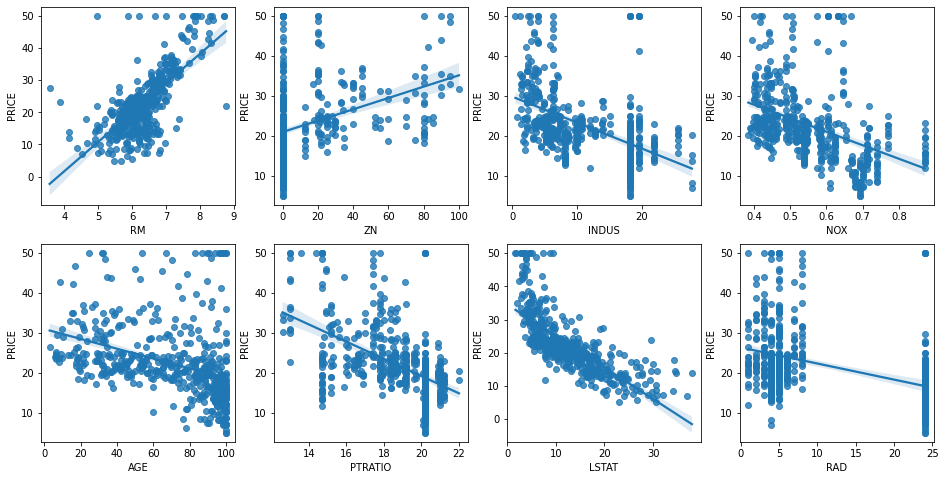

In [4]:
#2개의 행과 4개의 열을 가진 subplots를 이용, axs는 4*2개의 ax를 가짐
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
lm_features = ['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT', 'RAD']
for i, feature in enumerate(lm_features):
  row = int(i/4)
  col = i%4

  #시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표햔
  sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

- RM 과 LSTAT의 PRICE 영향도가 가장 두드러지게 나타남

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

#선형 회귀 OLS로 학습/예측/평가 수행
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse, rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297, RMSE : 4.159
Variance score : 0.757


In [8]:
print('절편 값 :', lr.intercept_)
print('회귀 계수값 : ', np.round(lr.coef_,1))

절편 값 : 40.995595172164755
회귀 계수값 :  [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [9]:
#회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성, 인덱스 칼럼명에 유의 
coeff = pd.Series(data=np.round(lr.coef_,1), index=X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

- RM이 가장 크며 NOX 의 -값이 너무 커보임

In [10]:
#5개의 폴드 세트에서 cross_vals_score() 이용해 교차검증으로 MSE, RMSE 추정

from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1)
lr = LinearRegression()

neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring = 'neg_mean_squared_error',cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds의 개별 Negative MSE scores : ', np.round(neg_mse_scores, 2))
print('5 folds의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print('5 folds의 평균 RMSE : {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores :  [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
5 folds의 평균 RMSE : 5.829
